<font size="18">Image Augmentation App</font>

This application demonstrates a simple rocAL pipeline with different augmentations supported by rocAL.<br>
Illustrated below how to create a pipeline with different augmentations, set outputs, build, run the pipeline and enumerate over the results.

<font size="12"> Common Code </font>

In [1]:
from amd.rocal.plugin.generic import ROCALClassificationIterator
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types
import matplotlib.pyplot as plt
%matplotlib inline


/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


<font size= "12" >Configuring rocAL pipeline </font>

Configure the pipeline paramters as required by the user.

In [2]:
data_path = "/media/MIVisionX-data/rocal_data/coco/coco_10_img/train_10images_2017/"
rocal_cpu = True
device = "cpu" 
batch_size =  1
num_threads = 1
random_seed = 1
local_rank =  0
world_size =  1
display = True 

In [3]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=local_rank, seed=random_seed, rocal_cpu=rocal_cpu, tensor_layout=types.NHWC , tensor_dtype=types.FLOAT)


Pipeline has been created succesfully
OK: loaded 114 kernels from libvx_rpp.so


<font size="12"> Image augmentation pipeline </font>

Here we use the file reader followed by the turbo jpeg decoder. In this pipeline we add cascaded augmentations on the decoded images.<br>We enable the output for different augmentations using set_outputs

In [4]:
with pipe:
        jpegs, _ = fn.readers.file(file_root=data_path)
        images = fn.decoders.image(jpegs, file_root=data_path, output_type=types.RGB, shard_id=0, num_shards=1, random_shuffle=True)
        resize_outputs = fn.resize(images, resize_width=300, resize_height=300)
        brightness_outputs = fn.brightness(resize_outputs)
        contrast_outputs = fn.contrast(resize_outputs)
        fisheye_outputs = fn.fish_eye(resize_outputs)
        fog_outputs = fn.fog(resize_outputs)
        exposure_outputs = fn.exposure(resize_outputs)
        color_twist_outputs = fn.color_twist(resize_outputs)
        saturation_outputs = fn.saturation(resize_outputs)
        pipe.set_outputs(resize_outputs, brightness_outputs, contrast_outputs, fisheye_outputs, fog_outputs, exposure_outputs, color_twist_outputs, saturation_outputs)

In [5]:
pipe.build()
# Dataloader
data_loader = ROCALClassificationIterator(pipe)

<font size ="12">Visualizing  outputs</font>

We have displayed the outputs of augmented images using imshow()

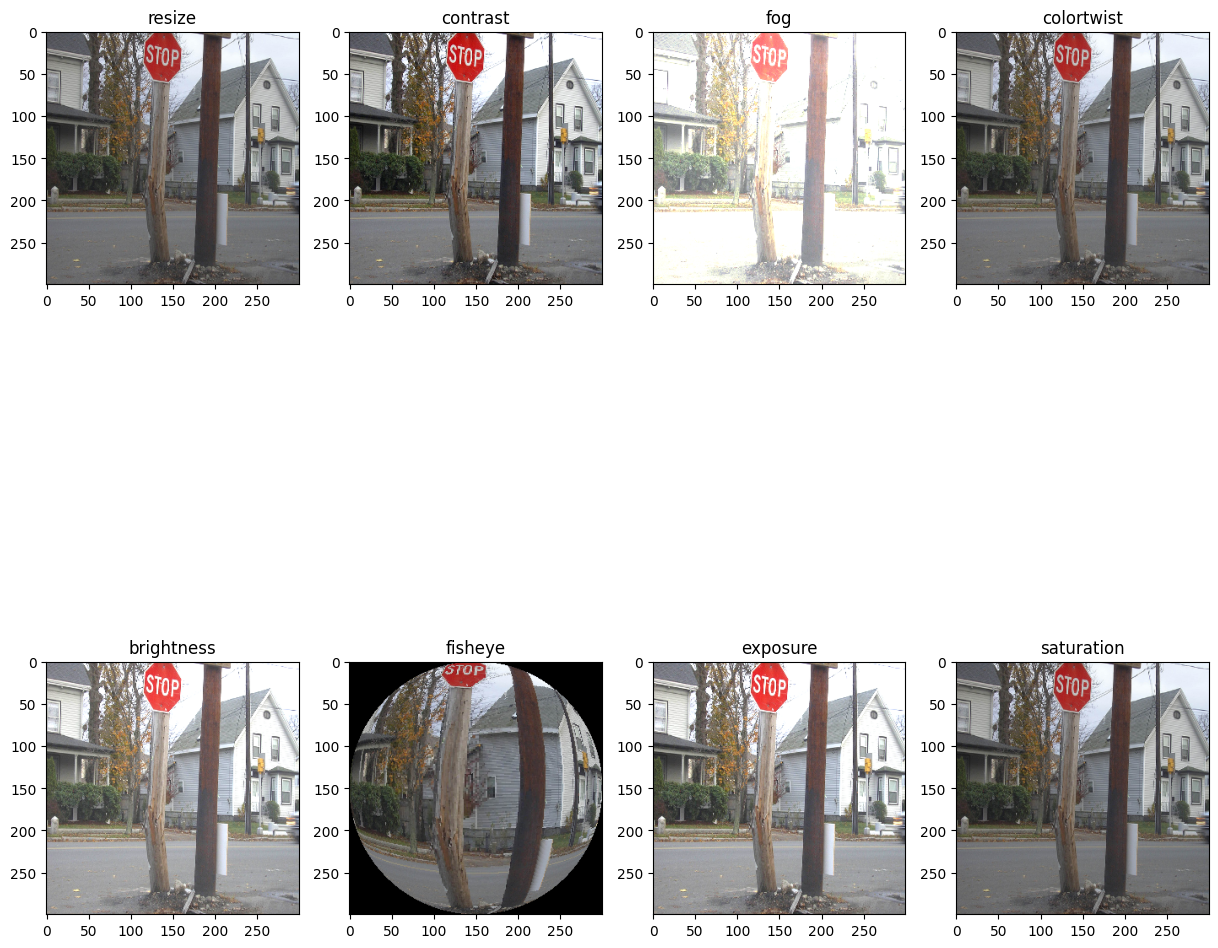

In [9]:
cnt = 0
aug_list = ["resize", "brightness", "contrast", "fisheye", "fog", "exposure", "colortwist", "saturation"] 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,15))
row = 0
col = 0
for i, it in enumerate(data_loader, 0):
    for img in it[0]:
        if(cnt < len(aug_list)):
            axes[row, col].set_title(aug_list[cnt])
        img = (img[0]).astype('uint8')
        axes[row, col].imshow(img)
        cnt = cnt + 1
        row += 1
        if(row == 2):
            row = 0
            col += 1
        if(col == 4):
            col = 0
data_loader.reset()